#### Fashion MNIST 

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
from numpy import genfromtxt
#from pymfe.mfe import MFE
import csv
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from io import StringIO
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import time
import random
from sklearn.model_selection import train_test_split 
import scipy
from scipy.stats import multivariate_normal
from numpy.random import seed
seed(2)
import tensorflow as tf
tf.random.set_seed(7)
import random
random.seed(1)
# In[5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Lambda, Input, Dense, Layer
from tensorflow.keras.layers import BatchNormalization,LayerNormalization
from tensorflow.keras.losses import mse, binary_crossentropy,categorical_crossentropy,sparse_categorical_crossentropy
from tensorflow.keras.layers import Activation, Dense, Flatten 
from tensorflow.keras import backend as K

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

C:\Users\91948\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### MNIST Data

In [2]:
# In[6]:


# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Change image shape to (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# In[7]:


start_dimension = x_train.shape[1]*x_train.shape[1]
x_train = np.reshape(x_train, [-1, start_dimension])
x_test = np.reshape(x_test, [-1, start_dimension])
# network parameters
input_shape = (start_dimension, )
intermediate_dim = 650
intermediate_dim2 = 300
batch_size = 64
latent_dim = 10
epochs = 1000

# In[8]:
print(x_train.shape)
print(x_test.shape)

# ### VAE
# In[9]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# In[10]:

# Encoder model
inputs = keras.Input(shape=input_shape, name='encoder_input')
x = layers.Dense(intermediate_dim, activation='relu')(inputs)
x = LayerNormalization(axis=1)(x)
x = layers.Dense(intermediate_dim2, activation='relu')(x)
x       = LayerNormalization(axis=1)(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling,
           output_shape=(latent_dim,), 
           name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# In[11]:

# Decoder model
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim2, activation='relu')(latent_inputs)
x = LayerNormalization(axis=1)(x)
x = layers.Dense(intermediate_dim, activation='relu')(x)
x = LayerNormalization(axis=1)(x)
outputs = layers.Dense(start_dimension, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# In[ ]:
# In[12]:

Trn_imb_set = (4000,2000,1000,750,500,350,200,100,60,40)
imb_index = np.insert(np.cumsum(Trn_imb_set), 0, 0)
# In[13]:
ximb_samples = np.zeros((np.sum(Trn_imb_set),x_train.shape[1]))

# In[14]:

ximb_samples.shape
# In[15]:
# Extract 0-9 classes for training the VAE

for i in range(num_classes):
    x_samples = x_train[y_train == i]
    x_s = x_samples[np.random.randint(0,x_samples.shape[0]-1, size=Trn_imb_set[i])]
    ximb_samples[imb_index[i]:imb_index[i+1],:] = x_s
    #y_samples = y_train[y_train == i]
    #drop_indices = (y_train == 0)
    #x_train = np.delete(x_train,drop_indices,axis =0)
    #y_train = np.delete(y_train,drop_indices,axis =0)

yimb_samples = np.hstack([np.zeros((4000,)),np.ones((2000,)),np.ones((1000,))*2,np.ones((750,))*3,
                np.ones((500,))*4,np.ones((350,))*5,np.ones((200,))*6,np.ones((100,))*7,
                 np.ones((60,))*8,np.ones((40,))*9])
yimb_samples = yimb_samples.astype('uint8')
    

# In[16]:

shuffled_indices = np.random.permutation((ximb_samples.shape[0])) #return a permutation of the indices

#print(f"shuffled indices: {shuffled_indices}")

ximb_samples = ximb_samples[shuffled_indices]

yimb_samples = yimb_samples[shuffled_indices].astype('uint8')

# In[17]:

X_imtrain, X_imval, y_imtrain, y_imval = train_test_split(ximb_samples, yimb_samples, 
                                                    test_size=0.2, random_state=1)


# ### 100 Testing samples
# In[18]:
tst_samples = 100
xtst_samples = np.zeros((tst_samples*num_classes,x_test.shape[1]))
for i in range(num_classes):
    x_tst = x_test[y_test == i]
    x_tst = x_tst[np.random.randint(0,x_tst.shape[0]-1, size=tst_samples)]
    print(i*100,(i+1)*100)
    xtst_samples[i*100:(i+1)*100,:] = x_tst
    
ytst_samples = np.hstack([np.zeros((100,)),np.ones((100,)),np.ones((100,))*2,np.ones((100,))*3,
                np.ones((100,))*4,np.ones((100,))*5,np.ones((100,))*6,np.ones((100,))*7,
                 np.ones((100,))*8,np.ones((100,))*9])
ytst_samples = ytst_samples.astype('uint8')
# In[19]:
ytst_samples.shape

# In[20]:


# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')
start_time = time.time()
# In[21]:

#if __name__ == '__main__':
def vaeFn(encoder,decoder):
    
    loss = 'bce'
    models = (encoder, decoder)
    data = (x_test, y_test)
    
    # VAE loss = mse_loss or xent_loss + kl_loss
    if loss == 'bce':
        reconstruction_loss = binary_crossentropy(inputs,
                                                  outputs)
    else:
        reconstruction_loss = mse(inputs, outputs)
        
    reconstruction_loss *= start_dimension
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    opt = keras.optimizers.Adam(lr=0.0005)
    vae.compile(optimizer=opt,)
    vae.summary()
            
    vae.fit(X_imtrain,
            epochs=epochs,
            #verbose = 10,
            batch_size=batch_size,
            validation_data=(X_imval, None))
    
    return models
    


# In[22]:


models = vaeFn(encoder,decoder)


# In[23]:
def latent_space_data(vae, data):
    encoder, decoder = vae
    z_mean, _, _ = encoder.predict(data)
    return z_mean
latent_space_imb01234 = latent_space_data(models, ximb_samples )
latent_space_imbTest = latent_space_data(models, xtst_samples)

# In[25]:

def metrics_aa_gm(ypred, ytrue):
    cm = confusion_matrix(ytrue, ypred)
    sum_classes = np.sum(cm, axis=1)
    true_pred = np.diagonal(cm)
    tp_rate = true_pred/sum_classes
    ACSA = np.mean(tp_rate)
    GM = np.prod(tp_rate)**(1/cm.shape[0])
    return ACSA, GM



# ### MSPO

# In[32]:




x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
(60000, 784)
(10000, 784)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 650)          510250      encoder_input[0][0]              
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 650)          1300        dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          195300      layer_normalization[0][0]  

C:\Users\91948\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 10), (None,  713470      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 784)          711234      encoder[0][2]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 650)          510250      encoder_input[0][0]              
____________________________________________________________________________________________

113/113 [==============================] - 4s 32ms/step - loss: 244.5315 - val_loss: 249.3867
Epoch 25/1000
113/113 [==============================] - 4s 35ms/step - loss: 244.3536 - val_loss: 247.8265
Epoch 26/1000
113/113 [==============================] - 3s 29ms/step - loss: 243.8648 - val_loss: 247.5186
Epoch 27/1000
113/113 [==============================] - 3s 28ms/step - loss: 244.0002 - val_loss: 249.2028
Epoch 28/1000
113/113 [==============================] - 3s 27ms/step - loss: 244.0477 - val_loss: 247.4406
Epoch 29/1000
113/113 [==============================] - 3s 28ms/step - loss: 243.3602 - val_loss: 247.2799
Epoch 30/1000
113/113 [==============================] - 3s 28ms/step - loss: 243.0604 - val_loss: 247.8235
Epoch 31/1000
113/113 [==============================] - 3s 29ms/step - loss: 243.0393 - val_loss: 247.2073
Epoch 32/1000
113/113 [==============================] - 3s 28ms/step - loss: 242.9165 - val_loss: 247.0669
Epoch 33/1000
113/113 [===================

Epoch 100/1000
113/113 [==============================] - 3s 28ms/step - loss: 236.4346 - val_loss: 243.8070
Epoch 101/1000
113/113 [==============================] - 3s 29ms/step - loss: 236.3318 - val_loss: 244.5924
Epoch 102/1000
113/113 [==============================] - 3s 28ms/step - loss: 236.4007 - val_loss: 244.9663
Epoch 103/1000
113/113 [==============================] - 3s 29ms/step - loss: 236.1979 - val_loss: 244.8788
Epoch 104/1000
113/113 [==============================] - 4s 31ms/step - loss: 236.8153 - val_loss: 243.8344
Epoch 105/1000
113/113 [==============================] - 3s 31ms/step - loss: 236.2382 - val_loss: 244.5340
Epoch 106/1000
113/113 [==============================] - 3s 27ms/step - loss: 236.0204 - val_loss: 244.1616
Epoch 107/1000
113/113 [==============================] - 3s 27ms/step - loss: 236.0809 - val_loss: 245.3679
Epoch 108/1000
113/113 [==============================] - 3s 30ms/step - loss: 235.9429 - val_loss: 244.6976
Epoch 109/1000
113/

113/113 [==============================] - 4s 39ms/step - loss: 233.8491 - val_loss: 244.8030
Epoch 176/1000
113/113 [==============================] - 5s 40ms/step - loss: 233.8443 - val_loss: 243.7638
Epoch 177/1000
113/113 [==============================] - 4s 34ms/step - loss: 233.8442 - val_loss: 244.3097
Epoch 178/1000
113/113 [==============================] - 4s 34ms/step - loss: 233.7469 - val_loss: 243.7731
Epoch 179/1000
113/113 [==============================] - 4s 32ms/step - loss: 233.8874 - val_loss: 244.3669
Epoch 180/1000
113/113 [==============================] - 4s 34ms/step - loss: 233.6951 - val_loss: 243.7708
Epoch 181/1000
113/113 [==============================] - 4s 39ms/step - loss: 233.6181 - val_loss: 243.9505
Epoch 182/1000
113/113 [==============================] - 5s 44ms/step - loss: 233.6778 - val_loss: 244.9040
Epoch 183/1000
113/113 [==============================] - 4s 34ms/step - loss: 233.4699 - val_loss: 244.2827
Epoch 184/1000
113/113 [==========

113/113 [==============================] - 3s 27ms/step - loss: 232.5529 - val_loss: 244.0268
Epoch 251/1000
113/113 [==============================] - 4s 36ms/step - loss: 232.4606 - val_loss: 244.2977
Epoch 252/1000
113/113 [==============================] - 3s 30ms/step - loss: 232.1974 - val_loss: 244.2647
Epoch 253/1000
113/113 [==============================] - 3s 27ms/step - loss: 232.6672 - val_loss: 244.4212
Epoch 254/1000
113/113 [==============================] - 3s 27ms/step - loss: 232.4109 - val_loss: 244.4399
Epoch 255/1000
113/113 [==============================] - 3s 26ms/step - loss: 232.2628 - val_loss: 244.0042
Epoch 256/1000
113/113 [==============================] - 3s 26ms/step - loss: 232.3476 - val_loss: 244.5733
Epoch 257/1000
113/113 [==============================] - 3s 25ms/step - loss: 232.3368 - val_loss: 244.4381
Epoch 258/1000
113/113 [==============================] - 3s 28ms/step - loss: 232.3690 - val_loss: 243.9375
Epoch 259/1000
113/113 [==========

113/113 [==============================] - 3s 24ms/step - loss: 231.5397 - val_loss: 243.9090
Epoch 326/1000
113/113 [==============================] - 3s 23ms/step - loss: 231.5641 - val_loss: 244.4123
Epoch 327/1000
113/113 [==============================] - 3s 23ms/step - loss: 231.4787 - val_loss: 244.7673
Epoch 328/1000
113/113 [==============================] - 2s 22ms/step - loss: 231.5639 - val_loss: 244.2182
Epoch 329/1000
113/113 [==============================] - 3s 25ms/step - loss: 231.6330 - val_loss: 244.4453
Epoch 330/1000
113/113 [==============================] - 3s 23ms/step - loss: 231.6007 - val_loss: 244.2883
Epoch 331/1000
113/113 [==============================] - 2s 22ms/step - loss: 231.5379 - val_loss: 244.4270
Epoch 332/1000
113/113 [==============================] - 2s 21ms/step - loss: 231.4772 - val_loss: 244.2387
Epoch 333/1000
113/113 [==============================] - 2s 21ms/step - loss: 231.3596 - val_loss: 244.4635
Epoch 334/1000
113/113 [==========

113/113 [==============================] - 2s 22ms/step - loss: 231.0351 - val_loss: 244.6377s 
Epoch 401/1000
113/113 [==============================] - 2s 21ms/step - loss: 231.1280 - val_loss: 244.1434
Epoch 402/1000
113/113 [==============================] - 2s 22ms/step - loss: 230.8971 - val_loss: 244.2501
Epoch 403/1000
113/113 [==============================] - 2s 22ms/step - loss: 231.0466 - val_loss: 244.2676
Epoch 404/1000
113/113 [==============================] - 2s 22ms/step - loss: 231.0349 - val_loss: 244.4484
Epoch 405/1000
113/113 [==============================] - 2s 22ms/step - loss: 230.8795 - val_loss: 244.1703
Epoch 406/1000
113/113 [==============================] - 2s 22ms/step - loss: 230.9962 - val_loss: 244.3902
Epoch 407/1000
113/113 [==============================] - 2s 22ms/step - loss: 231.0134 - val_loss: 244.1340
Epoch 408/1000
113/113 [==============================] - 2s 22ms/step - loss: 230.8994 - val_loss: 244.3408
Epoch 409/1000
113/113 [========

113/113 [==============================] - 3s 23ms/step - loss: 230.4276 - val_loss: 244.5650
Epoch 476/1000
113/113 [==============================] - 3s 25ms/step - loss: 230.5230 - val_loss: 244.3751
Epoch 477/1000
113/113 [==============================] - 3s 25ms/step - loss: 230.4452 - val_loss: 244.3425
Epoch 478/1000
113/113 [==============================] - 3s 25ms/step - loss: 230.5016 - val_loss: 244.4912
Epoch 479/1000
113/113 [==============================] - 3s 24ms/step - loss: 230.5640 - val_loss: 244.4550
Epoch 480/1000
113/113 [==============================] - 3s 24ms/step - loss: 230.5530 - val_loss: 244.4472
Epoch 481/1000
113/113 [==============================] - 3s 25ms/step - loss: 230.5665 - val_loss: 244.4641
Epoch 482/1000
113/113 [==============================] - 3s 25ms/step - loss: 230.4960 - val_loss: 244.2768
Epoch 483/1000
113/113 [==============================] - 3s 24ms/step - loss: 230.5891 - val_loss: 244.4400
Epoch 484/1000
113/113 [==========

113/113 [==============================] - 2s 22ms/step - loss: 230.2594 - val_loss: 244.2876
Epoch 551/1000
113/113 [==============================] - 2s 22ms/step - loss: 230.1418 - val_loss: 244.7523
Epoch 552/1000
113/113 [==============================] - 2s 22ms/step - loss: 230.2191 - val_loss: 244.1882
Epoch 553/1000
113/113 [==============================] - 2s 22ms/step - loss: 230.1839 - val_loss: 244.4294
Epoch 554/1000
113/113 [==============================] - 3s 22ms/step - loss: 230.3212 - val_loss: 244.3393
Epoch 555/1000
113/113 [==============================] - 2s 22ms/step - loss: 230.1570 - val_loss: 244.3879
Epoch 556/1000
113/113 [==============================] - 2s 22ms/step - loss: 230.1885 - val_loss: 244.4580
Epoch 557/1000
113/113 [==============================] - 2s 22ms/step - loss: 230.2351 - val_loss: 244.4663
Epoch 558/1000
113/113 [==============================] - 3s 22ms/step - loss: 230.0606 - val_loss: 244.4136
Epoch 559/1000
113/113 [==========

113/113 [==============================] - 2s 22ms/step - loss: 229.8085 - val_loss: 244.3489
Epoch 626/1000
113/113 [==============================] - 3s 22ms/step - loss: 229.7261 - val_loss: 244.2258
Epoch 627/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.9571 - val_loss: 244.7316
Epoch 628/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.8510 - val_loss: 244.6878
Epoch 629/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.8493 - val_loss: 244.6167
Epoch 630/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.9351 - val_loss: 244.7224
Epoch 631/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.8813 - val_loss: 244.3809
Epoch 632/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.7265 - val_loss: 244.3468
Epoch 633/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.9046 - val_loss: 244.8526
Epoch 634/1000
113/113 [==========

113/113 [==============================] - 2s 22ms/step - loss: 229.5280 - val_loss: 244.6525
Epoch 701/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.6458 - val_loss: 244.6895
Epoch 702/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.6567 - val_loss: 244.6431
Epoch 703/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.6359 - val_loss: 245.1450
Epoch 704/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.7022 - val_loss: 244.5116
Epoch 705/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.6423 - val_loss: 244.2345
Epoch 706/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.6989 - val_loss: 244.7061
Epoch 707/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.4746 - val_loss: 244.7966
Epoch 708/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.5959 - val_loss: 244.5169
Epoch 709/1000
113/113 [==========

113/113 [==============================] - 2s 22ms/step - loss: 229.4968 - val_loss: 244.3364
Epoch 776/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.4839 - val_loss: 244.5743
Epoch 777/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.4093 - val_loss: 245.0774
Epoch 778/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.3576 - val_loss: 244.9564
Epoch 779/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.3448 - val_loss: 244.5456
Epoch 780/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.3254 - val_loss: 244.7829
Epoch 781/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.4395 - val_loss: 244.8936
Epoch 782/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.5758 - val_loss: 244.4959
Epoch 783/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.4974 - val_loss: 244.3922
Epoch 784/1000
113/113 [==========

113/113 [==============================] - 3s 25ms/step - loss: 229.4094 - val_loss: 244.9928
Epoch 851/1000
113/113 [==============================] - 3s 23ms/step - loss: 229.3296 - val_loss: 245.2182
Epoch 852/1000
113/113 [==============================] - 3s 25ms/step - loss: 229.3259 - val_loss: 244.7102
Epoch 853/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.1181 - val_loss: 244.8324
Epoch 854/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.1625 - val_loss: 245.0431
Epoch 855/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.1625 - val_loss: 244.7396
Epoch 856/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.3096 - val_loss: 244.8003
Epoch 857/1000
113/113 [==============================] - 3s 23ms/step - loss: 229.1089 - val_loss: 244.8970
Epoch 858/1000
113/113 [==============================] - 3s 24ms/step - loss: 229.2117 - val_loss: 244.7817
Epoch 859/1000
113/113 [==========

113/113 [==============================] - 2s 22ms/step - loss: 229.0674 - val_loss: 244.7082
Epoch 926/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.0893 - val_loss: 244.5993
Epoch 927/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.1574 - val_loss: 244.8910
Epoch 928/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.1685 - val_loss: 245.1604
Epoch 929/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.0623 - val_loss: 244.7128
Epoch 930/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.1766 - val_loss: 244.9244
Epoch 931/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.2039 - val_loss: 244.7332
Epoch 932/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.0983 - val_loss: 245.2341
Epoch 933/1000
113/113 [==============================] - 2s 22ms/step - loss: 229.1003 - val_loss: 244.9155
Epoch 934/1000
113/113 [==========

113/113 [==============================] - 3s 23ms/step - loss: 228.9219 - val_loss: 245.3291


#### MSPO

In [3]:
def SPOfn(latent_space_im,mino,majo,y_d):
       
    
    nTarget = np.sum(y_d == majo)


    posy = y_d == mino
    negy = y_d != mino
    
    minority_count = np.sum(posy)
    imbalance_factor = np.sqrt(nTarget//minority_count)
    P = latent_space_im[np.where(posy == True)[0],:]
    N = latent_space_im[np.where(negy == True)[0],:]

    #print(len(P),len(N))

    poscnt = P.shape[0]
    NumToGen = nTarget - poscnt
    Me  = np.mean((P),axis = 0)
    PCov = np.cov(P.T)
    print(NumToGen)
    [D,V] = np.linalg.eig(PCov)
    #d = [D[x,x] for x in range(D.shape[0])]
    if poscnt<= 100:
        d = D
    else:
        d = D
    #d = d.astype(np.float32)
    n = P.shape[1] #Feature dimension
    idx = d.argsort()[::-1]   
    d = d[idx]
    V = V[:,idx]
    #d = d[0:n+1]
    #v = V[:,n::-1]

    Ind = (d<= 5e-03)

    if np.sum(Ind) != 0:
        M = (list(Ind).index(True)+1)
    else:
        M = n

    PN = np.concatenate((P,N),axis=0)
    TCov = np.cov(PN.T)
    dT    = np.dot(V.T,np.dot(TCov, V))
    dT = [dT[x,x] for x in range(dT.shape[0])]

    #Modify the Eigen spectrum according to a 1-Parameter Model
    dMod  = np.zeros((n,1))
    Alpha = d[0]* d[M-1]*(M-1) /(d[0] - d[M-1]) #d[0]* d[M-1]*(M-1) /(d[0] - d[M-1])
    Beta  = ((M)*d[M-1] - d[0])/(d[0] - d[M-1])


    for i in range(n):
        if i<M-1:

            dMod[i] = d[i]
        else:
            dMod[i] = Alpha/(i+1+Beta)
            if dMod[i] > dT[i]:
                dMod[i] = dT[i]

    R = 1
    d = dMod
    #print(d)
    
    ########################################
     
    Rn = M
    Un = len(Me) - M
    Ptemp = P

    MuR = np.zeros((Rn,1)) #mlayer#
    SigmaR = np.identity((Rn)) #v_mat #

    MuU = np.zeros((Un,1))
    SigmaU = np.identity((Un))

    SampGen = np.zeros((int(NumToGen*R), len(Me)))
    SampSel = np.zeros((int(NumToGen), len(Me)))
    Prob    = np.zeros((int(NumToGen*R),1))

    cnt = 0
    DD = np.sqrt(d)
    MuR = MuR.reshape(MuR.shape[0],)
    MuU = MuU.reshape(MuU.shape[0],)

    while cnt < int(R*NumToGen):

        aR =  np.random.multivariate_normal(MuR.T, SigmaR, 1)
        #print(aR)
        #scipy.stats.multivariate_normal(MuR.T, SigmaR, 1)
        tp = multivariate_normal.pdf(aR, MuR, SigmaR) #aR.pdf(1)
        #print(tp)

        if Un > 0:
            aU = np.random.multivariate_normal(MuU, SigmaU, 1)
            #scipy.stats.multivariate_normal(MuU, SigmaU, 1)
            a = np.multiply(np.concatenate((aR,aU),axis=1).T,DD)   #The vector in Eigen transformed domain;
        else:
            a = np.multiply(aR.T,DD)
            #print(a)

        x = np.dot(a.T,V.T)+ Me
        #print(x)
        #pdb.set_trace()
        PDist = np.sqrt(np.sum(np.square((x-P)),axis=1))
        NDist = np.sqrt(np.sum(np.square((x-N)),axis=1))

        [tmp,ind]  = [np.min(NDist),np.argmin(NDist)]

        if np.min(PDist) < tmp:
            PPDist = np.sqrt(np.sum(np.square((N[ind,:]-P)),axis=1))
            if tmp >= np.min(PPDist) and tmp <= np.max(PPDist):
                SampGen[cnt,:] = x
                Prob[cnt,0] = tp  
                cnt+=1
                Ptemp = np.concatenate((Ptemp,SampGen),axis =0)

    for i in range(NumToGen):
        [tmp,ind]  = [np.min(Prob),np.argmin(Prob)]
        Prob[ind] =  np.inf
        SampSel[i,:] = SampGen[ind,:]

    Ynew = SampSel #np.concatenate((SampSel,P),axis = 0)
    #Total = np.concatenate((Ynew,N),axis = 0)
    
    return Ynew


# In[33]:


Total = latent_space_imb01234#[yimb_samples == 0]
y_tot = yimb_samples #np.zeros((np.sum(yimb_samples == 0),))
for i in range(10):
    Newsamples = SPOfn(Total,i,0,y_tot)
    y_tot = np.concatenate((y_tot,np.ones((Newsamples.shape[0],))*i),axis = 0)
    Total = np.concatenate((Total,Newsamples),axis = 0)


# In[37]:

0
2000
3000
3250
3500
3650
3800
3900
3940
3960


In [4]:
X_train = (Total)
y_train = (y_tot)
X_test = (latent_space_imbTest)
y_test = (ytst_samples)

#X_train, X_test, y_train, y_test = train_test_split(X,y_im,random_state=1, test_size=0.1)
mm_X = MinMaxScaler(feature_range=(0,1))
X_trainscaled= mm_X.fit_transform(X_train)
X_testscaled= mm_X.transform(X_test)


In [13]:
# ### MLP on SPO latent space

# In[95]:


def classfrspo(X_train,y_train,X_test,y_test):
    
    clf = MLPClassifier(solver='sgd',shuffle = True,batch_size = 250, 
                        hidden_layer_sizes=(24,256,30,),activation="relu",
                        momentum = 0.91,random_state=1,max_iter = 5000, 
                        learning_rate_init=0.00361,learning_rate='adaptive',
                        alpha = 0.00011,warm_start=True)
    
    clf.fit(X_trainscaled, y_train)
    y_pred=clf.predict(X_testscaled)
    print(clf.score(X_testscaled, y_test))
    
    target_names = ['class 0', 'class 1','class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
    print(classification_report( y_pred,y_test, target_names=target_names))
    return y_pred,clf

# In[96]: 0.00361


y_pred,clf = classfrspo(X_train,y_train,X_test,y_test)


# In[92]:


acsa, gm, = metrics_aa_gm(y_pred, ytst_samples) 
print (acsa, gm,)



0.826
              precision    recall  f1-score   support

     class 0       0.94      0.68      0.79       139
     class 1       0.98      0.97      0.98       101
     class 2       0.81      0.70      0.75       115
     class 3       0.87      0.88      0.87        99
     class 4       0.67      0.73      0.70        92
     class 5       0.93      0.85      0.89       109
     class 6       0.42      0.74      0.54        57
     class 7       0.91      0.85      0.88       107
     class 8       0.84      0.95      0.89        88
     class 9       0.89      0.96      0.92        93

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.82      1000
weighted avg       0.85      0.83      0.83      1000

0.826 0.8059119448823105


Cross Validation
ACSA,GM: 0.826 0.8059119448823105
ACSA,GM: 0.826 0.8059119448823105
ACSA,GM: 0.826 0.8059119448823105
ACSA,GM: 0.8270000000000002 0.8071067952141441
ACSA,GM: 0.826 0.8059119448823105
ACSA,GM: 0.826 0.8059119448823105
ACSA,GM: 0.826 0.8059119448823105
ACSA,GM: 0.826 0.8059119448823105
ACSA,GM: 0.826 0.8059119448823105
ACSA,GM: 0.826 0.8059119448823105
Time taken: 44697.294327259064


(-0.5, 279.5, 279.5, -0.5)

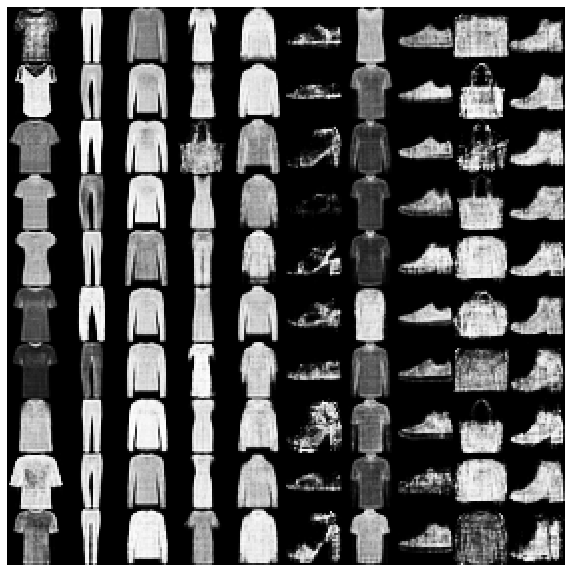

In [14]:
kf = KFold(n_splits=10,)
print("Cross Validation")

for train_indices, test_indices in kf.split((X_trainscaled)):
    clf.fit(X_trainscaled[train_indices], y_train[train_indices])
    # print(clf.score(X_testscaled, y_test))

    y_pred=clf.predict(X_testscaled)
    acsa, gm = metrics_aa_gm(y_pred, y_test)
    print ('ACSA,GM:',acsa, gm,)

print("Time taken:",time.time()-start_time)

#### Generate images

encoder, decoder = models
Tiles = np.zeros((280,280))

for i in range(10):
    for j in range(10):
        index =random.randint(2000,3999)
        points9 = Total[y_tot==j]
        inp = np.reshape(points9[index], [-1, 10])
        I_decoded = decoder.predict(inp)
        Tiles[i*28:(i+1)*28,j*28:(j+1)*28] = np.reshape(I_decoded,[28,28])
        
plt.figure(figsize=(10,18))
plt.imshow(Tiles,cmap='gray')
plt.axis('off')
#plt.savefig("fashionmnist_generatedimages.png", bbox_inches='tight')
